<img src="https://raw.githubusercontent.com/Harmonize-Brazil/code-gallery/main/img/INPE_logo.png" align="left" style="height: 105px" height="105"/>
<!-- https://www.gov.br/mcti/pt-br/composicao/rede-mcti/instituto-nacional-de-pesquisas-espaciais -->
<img src="https://raw.githubusercontent.com/Harmonize-Brazil/code-gallery/main/img/harmonize_logo_without_white_background.png" align="right" style="height: 90px" height="90"/>

<h1 style="color:#274ad4; text-align: center">Exploring multiscale data: orbital and drone imagery</h1>
<h3 style="color:#274ad4; text-align: center">Accessing and visualizing data from Sentinel-2A and drone imagery using BDC-STAC and WTSS services  </h3>
<hr style="border:2px solid #274ad4;">
<br/>


<div style="text-align: center;font-size: 90%;">
    Ana Paula Dal'Asta<sup><a href="https://orcid.org/0000-0002-1286-9067" target="_blank" rel="noopener noreferrer"><img src="https://orcid.filecamp.com/static/thumbs/folders/qLJ1tuei4m6ugC3g.png" width="16"alt="ORCID iD" style="vertical-align: text-bottom;"/></a></sup>
    Marcos L. Rodrigues<sup><a href="https://orcid.org/0000-0002-9199-6928" target="_blank" rel="noopener noreferrer"><img src="https://orcid.filecamp.com/static/thumbs/folders/qLJ1tuei4m6ugC3g.png" width="16"alt="ORCID iD" style="vertical-align: text-bottom;"/></a></sup>
    Luana Becker da Luz<sup><a href="https://orcid.org/0000-0003-2535-7658\" target="_blank" rel="noopener noreferrer"><img src="https://orcid.filecamp.com/static/thumbs/folders/qLJ1tuei4m6ugC3g.png" width="16"alt="ORCID iD" style="vertical-align: text-bottom;"/></a></sup>
    <br/><br/>
    Earth Observation and Geoinformatics Division, National Institute for Space Research (INPE)
    <br/>
    Avenida dos Astronautas, 1758, Jardim da Granja, São José dos Campos, SP 12227-010, Brazil
    <br/><br/>
    Last Update: November, 2025
</div>

<br/>

<div style="text-align: justify; 
            width: 60%; 
            margin-left: auto; 
            margin-right: auto; 
            font-size: 15px; 
            line-height: 1.6;">

<b>Abstract.</b> 
This Jupyter Notebook gives an overview of how to use the BDC-STAC and WTSS services implementation to discover and access the satellite and drone data products from the Earth Observation Data Cubes tuned for Health Response Systems (EODCtHRS), a 
<a href="https://harmonize-tools.org" target="_blank">HARMONIZE project</a> component. 
This notebook was adapted from 
<a href="https://github.com/brazil-data-cube/code-gallery/blob/master/jupyter/Python/stac/stac-introduction.ipynb" target="_blank">Introduction to the SpatioTemporal Asset Catalog (STAC)</a> 
and 
<a href="https://github.com/brazil-data-cube/code-gallery/blob/master/jupyter/Python/wtss/wtss-introduction.ipynb" target="_blank">Introduction to the Web Time Series Service (WTSS)</a>, 
available at the GitHub code gallery of the 
<a href="https://data.inpe.br/bdc/web" target="_blank">Brazil Data Cube (BDC)</a> project.

</div>
</div>

## STAC Client API
<hr style="border:1px solid #274ad4;">

#### For running the examples in this Jupyter Notebook you will need to install the [pystac-client](https://pystac-client.readthedocs.io/en/latest/). To install it from PyPI using `pip`, use the following commands:

In [ ]:
try:
    import sklearn
except ImportError:
    %pip install scikit-learn
    import sklearn  # <- reimporta

try:
    import pystac_client
except ImportError:
    %pip install pystac-client
    import pystac_client  # <- reimporta


#### Installing additional libraries for processing and visualization:

In [ ]:
import importlib

for module in ['rasterio','shapely','matplotlib','tqdm','folium']:
    try:
        importlib.import_module(module)
    except ImportError:
        %pip install -q {module}

#### In order to access the funcionalities of the client API, you should import the `stac` package, as follows:

In [ ]:
import pystac_client

#### Then, create a `STAC` object attached to the HARMONIZE instance of BDC-STAC service:

In [ ]:
service = pystac_client.Client.open('https://brazildatacube.dpi.inpe.br/harmonize/dev/stac/v1/')

## Available image data
<hr style="border:1px solid #274ad4;">

#### Using the STAC object, it is possible to list all image and data cube collections available from the service. 
Here we have used a keyword (`FlightHeight`) to retrieve only collections related to drone data:

In [ ]:
for collection in service.get_collections():
    #print(collection)
    if "FlightHeight" in collection.id: #keyword for collections from drone data
         print(collection)

#### Retrieving the MAVIC 3M drone data collection 
In addition, the mosaics available in this collection can be explored using the STAC Browser, an application with an interactive graphical interface that enables users to search, visualize, and access STAC catalogs: https://radiantearth.github.io/stac-browser/#/external/geolab.inpe.br/bdc/harmonize/stac/v1/collections/Mavic3M_FlightHeight120m_Mosaic-1

In [ ]:
collection = service.get_collection('Mavic3M_FlightHeight120m_Mosaic-1')
collection.description

In [ ]:
search = service.search(collections=["Mavic3M_FlightHeight120m_Mosaic-1"])
collection_items = search.item_collection()

for item in collection_items:
    print(item)

#### Selecting the mosaic corresponding to Bairro Novo (Mocajuba, Baixo Tocantins, Pará)

Extract the bounding box of the selected item. This bounding box will be used to query Sentinel-2 images in the BDC.

In [ ]:
collection_item = collection.get_item('Mavic3M_120m_Mosaic_Mocajuba_BairroNovo_20231107')

In [ ]:
bbox = collection_item.bbox
print("Bounding Box:", bbox)

#### Visualization of a Region Of Interest (ROI):

In [ ]:
import folium

# Bounding box 
bbox = [-49.49865191772988, -2.575056021073355, -49.49006266893534, -2.567952819171104]

# Define the center location
center = [(bbox[1] + bbox[3]) / 2, (bbox[0] + bbox[2]) / 2]

# Create a folium map centered around the geographic area of interest
m = folium.Map(location=center, zoom_start=17, control_scale=True)

# Add the BBOX
folium.Rectangle(
    bounds=[[bbox[1], bbox[0]], [bbox[3], bbox[2]]],  # [[lat_min, lon_min], [lat_max, lon_max]]
    color="blue",
    fill=True,
    fill_color="blue",
    fill_opacity=0.3,
    weight=2
).add_to(m)

m


#### Accessing orbital imagery (cubes) from the BDC
Using pystac-client to discover and access the BDCdata cube collections

In [ ]:
service_bdc = pystac_client.Client.open('https://data.inpe.br/bdc/stac/v1/')

In [ ]:
for collection in service_bdc.get_collections():
    print(collection)

In [ ]:
collection = service_bdc.get_collection('S2-16D-2')
collection

## Web Time Series Service (WTSS) service
<hr style="border:1px solid #274ad4;">

#### Web Time Series Service (WTSS) is a lightweight web service for handling time series data from remote sensing imagery. Given a location and a time interval you can retrieve the according time series. It allows users to query and access historical data, such as satellite imagery, for a specific location and time interval. 
##### Using the WTSS to retrieve NDVI temporal profiles for selected sample points. In this example, we explore NDVI from the Sentinel-2 cube at three sample points in Bairro Novo. 


#### Installing the WTSS client for python

In [ ]:
%pip install wtss

In [ ]:
%pip install setuptools

#### Importing the WTSS client and defining the service to be used


In [ ]:
from wtss import WTSS

In [ ]:
service = WTSS('https://data.inpe.br/bdc/wtss/v4/')

#### Listing the available data products and retrieving the metadata of a data product

In [ ]:
service.coverages

In [ ]:
coverage = service['S2-16D-2']
coverage

#### Extracting the NDVI time series from the samples

In [ ]:
ts1 = coverage.ts(attributes=('NDVI'),
                 latitude=-2.5708426083, longitude=-49.4906484667,
                 start_date='2023-01-01', end_date='2023-12-31')

ts2 = coverage.ts(attributes=('NDVI'),
                 latitude=-2.5720176216, longitude=-49.4917217939,
                 start_date='2023-01-01', end_date='2023-12-31')

ts3 = coverage.ts(attributes=('NDVI'),
                 latitude=-2.5725895089, longitude=-49.4966944316,
                 start_date='2023-01-01', end_date='2023-12-31')


In [ ]:
ts1

### NOTE: NDVI bands precomputed by BDC ranges from -10000 to 10000, instead of -1 to 1, as can be seen in the item metadata. This is due to the lower volume required to store files that use 16-bit integer values rather than 32-bit float.

#### Plot the NDVI 

In [ ]:
ts1.plot()

In [ ]:
import matplotlib.pyplot as plt

# Create the figure
plt.figure(figsize=(10,5))

# Plot the 3 time series
plt.plot(ts1.timeline, ts1.NDVI, '-', color="#ab08cb", linewidth=1, label="Point 1", alpha=0.9)
plt.plot(ts2.timeline, ts2.NDVI, '-', color="#105506", linewidth=1, label="Point 2", alpha=0.9)
plt.plot(ts3.timeline, ts3.NDVI, '-', color="#b96a10", linewidth=1, label="Point 3", alpha=0.9)

# Graph adjustments
plt.ylabel("NDVI")
plt.xlabel("Data")
plt.grid(alpha=0.3)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### Mosaic visualization 
Given the mosaic’s substantial file size, proper visualization requires downscaling. In this example, the code performs the downscaling, without downloading the full mosaic, and renders the point locations on top of it.

#### Plot the points

In [ ]:
collection_item

In [ ]:
import rasterio

with rasterio.open(collection_item.assets['file'].href) as rgb_ds:
    rgb = rgb_ds.read()
    rgb_epsg = rgb_ds.crs.to_epsg()
    rgb_bounds = rgb_ds.bounds    

In [ ]:
from pyproj import Transformer, CRS

def transform_coordinates(x, y, source_epsg):
    """
    Transforms coordinates from a source EPSG to EPSG 4326.

    Args:
        x (float): X coordinate (easting/longitude).
        y (float): Y coordinate (northing/latitude).
        source_epsg (int): EPSG code of the source coordinate system.

    Returns:
        tuple: (longitude, latitude) in EPSG 4326.
    """
    source_crs = CRS.from_epsg(source_epsg)
    target_crs = CRS.from_epsg(4326)
    transformer = Transformer.from_crs(source_crs, target_crs, always_xy=True)
    lon, lat = transformer.transform(x, y)
    return lon, lat

In [ ]:
#bbox RGB to EPSG 4326:
rgb_left_4326,rgb_top_4326 = transform_coordinates(rgb_bounds[0], rgb_bounds[3], rgb_epsg)
rgb_right_4326,rgb_bottom_4326 = transform_coordinates(rgb_bounds[2], rgb_bounds[1], rgb_epsg)

In [ ]:
#Add alpha channel and format axis to plot using Folium
import numpy
from rasterio.plot import reshape_as_image

#Adapted from https://github.com/python-visualization/folium/issues/1470#issuecomment-1490511046
def add_alpha(rgb_img):
  alpha_channel = numpy.ones((rgb_img.shape[1], rgb_img.shape[2]), dtype=int)  # create a new alpha channel with all values set to 1
  alpha_channel[(rgb_img[0] == 0) & (rgb_img[1] == 0) & (rgb_img[2] == 0)] = 0 # set alpha values to 0 for pixels where all RGB values are 0
  rgba_image = numpy.concatenate((rgb_img, alpha_channel[numpy.newaxis, :, :]), axis=0) # concatenate the alpha channel with the RGB image along the first dimension to create a RGBA image
  return rgba_image

rgba = rasterio.plot.reshape_as_image(add_alpha(rgb))

In [ ]:
# Convert drone mosaic 
rgba_uint8 = rgba.astype("uint8")

In [ ]:
from PIL import Image
import numpy as np

# Create a PIL image from the array (H, W, 4)
img = Image.fromarray(rgba_uint8)

# define a maximum size for visualization
max_size = (2048, 2048)   # (max_width, max_height)

# Resize while preserving aspect ratio
img.thumbnail(max_size)   # modifica in-place

# convert back to numpy
rgba_small = np.array(img)
print("area:", rgba_small.shape)

# keep only RGB (discard the alpha channel, which was 0/1)
rgb_small = rgba_small[:, :, :3]  # shape (h, w, 3)

print("mosaic:", rgb_small.shape, "dtype:", rgb_small.dtype)


In [ ]:
import folium
from urllib.parse import quote

# Create a folium map centered around the geographic area of interest
m = folium.Map(location=center, zoom_start=18, control_scale=True, max_zoom=25)

# Overlay the mosaic
folium.raster_layers.ImageOverlay(
    image=rgb_small,
    bounds=[[rgb_bottom_4326, rgb_left_4326],
            [rgb_top_4326,    rgb_right_4326]],
    name="RGB",
    opacity=1.0,         # opaco
    cross_origin=True,
    interactive=False
).add_to(m)

# Draw the bbox outline
folium.Rectangle(
    [[rgb_bottom_4326, rgb_left_4326],
     [rgb_top_4326,    rgb_right_4326]],
    color="#2c7fb8",
    weight=1,
    fill=False
).add_to(m)

# Tree points
points = [
    (-2.5708426083, -49.4906484667),
    (-2.5720176216, -49.4917217939),
    (-2.5725895089, -49.4966944316),
]
cores = ["#ab08cb", "#105506", "#b96a10"]
for i, (lat, lon) in enumerate(points, start=1):
    folium.CircleMarker([lat, lon], radius=6, color=cores[i-1],
                        fill=True, fill_opacity=0.95,
                        popup=f"Ponto {i}").add_to(m)

folium.LayerControl().add_to(m)
m.fit_bounds([
    [rgb_bottom_4326, rgb_left_4326],
    [rgb_top_4326,    rgb_right_4326]
])

# Display map
m


# Drone data: Access using the BDC-STAC service 
<hr style="border:1px solid #274ad4;">

## Retrieving the Metadata of a Collection

The `collection` object associated as a result of the  `get_collections` method has information about a given image or data cube collection identified by its name. In this example, we are retrieving information about the Mavic 3M RGB images collection, Mavic3M_FlightHeight120m-1:

In [ ]:
service = pystac_client.Client.open('https://brazildatacube.dpi.inpe.br/harmonize/dev/stac/v1/')

In [ ]:
for collection in service.get_collections():
    #print(collection)
    if "FlightHeight" in collection.id: #keyword for collections from drone data
         print(collection)

In [ ]:
collection = service.get_collection('Mavic3M_FlightHeight120m-1')
collection


# Using Matplotlib to Visualize NDVI
<hr style="border:1px solid #274ad4;">


The Mavic 3 Multispectral has two forms of sight. It combines an RGB camera with a multispectral camera to scan and analyze crop growth with total clarity. Agricultural production management requires precision and data, and Mavic 3M delivers both.

Source: [DJI Mavic 3m](https://ag.dji.com/mavic-3-m?backup_page=index)


Besides RGB images, we have also produced multispectral images from (NIR, Red Edge, Red and Green) bands and NDVI with Mavic 3M data. All these products are available at the STAC service:

In [ ]:
# Get Mavic 3M multispectral data collection:
collection = service.get_collection('Mavic3M_FlightHeight120m_MS-1')
collection.description

In [ ]:
search = service.search(collections=["Mavic3M_FlightHeight120m_MS-1"])
collection_items = search.item_collection()

for item in collection_items:
    print(item)

In [ ]:
collection_item = collection.get_item('Mavic3M_120m_MS_Mocajuba_BairroNovo_20231107202757')

In [ ]:
collection_item.assets 

### Overview of item based on thumbnail
<img src="https://brazildatacube.dpi.inpe.br/harmonize/dev/data/Mavic3M_FlightHeight120m_MS/2023/11/Mocajuba_BairroNovo_20231107T202757_MS.png">

### Ploting NDVI

In [ ]:
asset = collection_item.assets['NDVI']

Using `extra_fields` from asset, we can see information needed to plot properly the vegetation indice raster. For example, `scale`, `nodata`, etc.:

In [ ]:
asset.extra_fields

In [ ]:
import rasterio

with rasterio.open(asset.href) as raster_ds:
    ndvi = raster_ds.read(1)
    left, bottom, right, top = raster_ds.bounds

In [ ]:
import numpy 

# Mask nodata and apply scale to get original values of NDVI:
nodata = asset.extra_fields['eo:bands'][0]['nodata']
scale = asset.extra_fields['eo:bands'][0]['scale']
ndvi = numpy.ma.masked_values(ndvi, nodata) * scale
print('NDVI range of values:',numpy.ma.min(ndvi),numpy.ma.max(ndvi))

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

# Define a custom colormap for NDVI
colors = ["brown", "yellow", "green"]
cmap_ndvi = LinearSegmentedColormap.from_list("ndvi", colors)

im1 = plt.imshow(ndvi, extent=(left, right, bottom, top),cmap=cmap_ndvi,vmin=-1.0,vmax=1.0)
plt.colorbar(im1, label='NDVI');


## Testing NDVI with BDC Datacube

In [ ]:
from pyproj import Transformer, CRS

def transform_coordinates(x, y, source_epsg):
    """
    Transforms coordinates from a source EPSG to EPSG 4326.

    Args:
        x (float): X coordinate (easting/longitude).
        y (float): Y coordinate (northing/latitude).
        source_epsg (int): EPSG code of the source coordinate system.

    Returns:
        tuple: (longitude, latitude) in EPSG 4326.
    """
    source_crs = CRS.from_epsg(source_epsg)
    target_crs = CRS.from_epsg(4326)
    transformer = Transformer.from_crs(source_crs, target_crs, always_xy=True)
    lon, lat = transformer.transform(x, y)
    return lon, lat

In [ ]:
# Example usage:
source_epsg = 26917  # Example: NAD83 / UTM zone 17N
x = 500000.0
y = 4000000.0
lon, lat = transform_coordinates(x, y, source_epsg)
print(f"Original coordinates (EPSG:{source_epsg}): x={x}, y={y}")
print(f"Transformed coordinates (EPSG:4326): lon={lon}, lat={lat}")

In [ ]:
#bbox ndvi to EPSG 4326:
source_epsg = raster_ds.crs.to_epsg()
left_4326,top_4326 = transform_coordinates(left, top, source_epsg)
right_4326,bottom_4326 = transform_coordinates(right, bottom, source_epsg)

####  Visualization of a Region Of Interest (ROI) defined to filter items:

In [ ]:
import folium
from shapely.geometry import Polygon

bbox = [left_4326,bottom_4326,right_4326,top_4326] #define ROI bounding box

roi_area = Polygon([(bbox[0],bbox[1]),
                    (bbox[0],bbox[3]),
                    (bbox[2],bbox[3]),
                    (bbox[2],bbox[1])])


# Create a folium map centered around the geographic area of interest
folium_map = folium.Map(location=[roi_area.centroid.y, roi_area.centroid.x], zoom_start=19,
                        control_scale=True, zoom_control=False)

folium.Rectangle(
    bounds=[[bbox[1],bbox[0]],[bbox[3],bbox[2]]],
    color="blue",
    weight=2,
    fill=True,
    fill_color="blue",
    fill_opacity=0.2
).add_to(folium_map)

folium_map

## Searching Sentinel item near of drone data (BDC STAC)

In [ ]:
item_search = service_bdc.search(bbox=bbox,
                             datetime='2023-11-01/2023-11-07',
                             collections=['S2-16D-2'])
item_search

In [ ]:
item_search.matched()

In [ ]:
for item in item_search.items():
    print(item)

In [ ]:
assets = item.assets
for k in assets.keys():
    print(k)

##### Read NDVI from Sentinel 2 for drone bounding box:

In [ ]:
src = rasterio.open(assets['NDVI'].href)
s2_ndvi_info = assets['NDVI'].to_dict()

If you wish you can use lat long coordinates and reproject them into the Albers Equal Area Projection, which is used in the BDC products:

In [ ]:
from pyproj import Transformer
from pyproj.crs import CRS
from rasterio.windows import from_bounds

inProj = CRS.from_epsg(4326)
outProj = CRS.from_user_input(src.crs)
transformer = Transformer.from_crs(inProj, outProj, always_xy=True)
x1, y1 = left_4326, bottom_4326
x2, y2 = right_4326, top_4326
x1_reproj, y1_reproj = transformer.transform(x1, y1)
x2_reproj, y2_reproj = transformer.transform(x2, y2)
print('Bounding box of drone using EPSG 4326:',x1, y1, x2, y2)
print('Bounding box of drone using Albers Equal Area Projection (datacube):',x1_reproj, y1_reproj, x2_reproj, y2_reproj)

with rasterio.open(assets['NDVI'].href) as src:
    ndvi_s2 = src.read(1, window=from_bounds(x1_reproj, y1_reproj, x2_reproj, y2_reproj, src.transform))
print(ndvi_s2.shape)

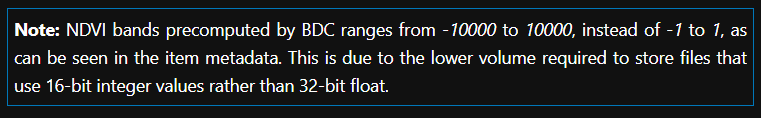

In [ ]:
import os
os.environ['PROJ_LIB'] = '/opt/conda/share/proj' #to prevent proj error!

from cartopy import crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from matplotlib.colors import LinearSegmentedColormap

# Define a custom colormap for NDVI
colors = ["brown", "yellow", "green"]
cmap_ndvi = LinearSegmentedColormap.from_list("ndvi", colors)

# Plot
fig = plt.figure(figsize=(8,7), dpi=100) # open matplotlib figure

# Define the CartoPy CRS object.
crs = ccrs.PlateCarree()  

#######################################
# Formatting the Cartopy plot
#######################################
ax1 = plt.axes(projection=crs) # project using coordinate reference system (CRS)
extent = (left_4326, right_4326, bottom_4326, top_4326)
ax1.set_extent(extent) # set extents
im1 = ax1.imshow(ndvi_s2 * s2_ndvi_info['eo:bands'][0]['scale'], extent=(left_4326, right_4326, bottom_4326, top_4326),cmap=cmap_ndvi, vmin=-1,vmax=1)
plt.colorbar(im1, label='NDVI');

# Create formatted x and y ticks:
ax1.set_xticks(numpy.linspace(extent[0],extent[1],7),crs=ccrs.PlateCarree()) # set longitude indicators
ax1.set_yticks(numpy.linspace(extent[2],extent[3],7)[1:],crs=ccrs.PlateCarree()) # set latitude indicators
lon_formatter = LongitudeFormatter(number_format='0.4f',degree_symbol='',dateline_direction_label=True) # format lons
lat_formatter = LatitudeFormatter(number_format='0.4f',degree_symbol='') # format lats
ax1.xaxis.set_major_formatter(lon_formatter) # set lons
ax1.yaxis.set_major_formatter(lat_formatter) # set lats
ax1.xaxis.set_tick_params(labelsize=8)
ax1.yaxis.set_tick_params(labelsize=8)

teste = ndvi_s2 * s2_ndvi_info['eo:bands'][0]['scale']
print(teste.min(),teste.max())

In [ ]:
# Create a figure with two subplots with a same projection
fig, axs = plt.subplots(1, 2, figsize=(12, 6), dpi=150, subplot_kw={'projection': ccrs.PlateCarree()})  # Subplot uses Plate Carree
ax1 = axs[0]
ax2 = axs[1]

# Plot data on each subplot
im1 = ax1.imshow(ndvi, extent=(left_4326, right_4326, bottom_4326, top_4326),cmap=cmap_ndvi, vmin=-1,vmax=1)
ax2.imshow(ndvi_s2 * scale, extent=(left_4326, right_4326, bottom_4326, top_4326),cmap=cmap_ndvi, vmin=-1,vmax=1)

# Set titles for individual subplots
ax1.set_title("Mavic 3M (Bairro Novo - Mocajuba) 07/11/2023", fontsize=8)
ax2.set_title("S2 data cube 16 days (Bairro Novo - Mocajuba) 01/11/2023", fontsize=8)

# Create a colorbar for both subplots, spanning the figure
fig.colorbar(im1, label='NDVI', ax=axs.ravel().tolist(), shrink=0.9)
#plt.colorbar(im1, label='NDVI');

# Create formatted x and y ticks:
for ax in axs:
    ax.set_xticks(numpy.linspace(extent[0],extent[1],7),crs=ccrs.PlateCarree()) # set longitude indicators
    ax.set_yticks(numpy.linspace(extent[2],extent[3],7)[1:],crs=ccrs.PlateCarree()) # set latitude indicators
    lon_formatter = LongitudeFormatter(number_format='0.4f',degree_symbol='',dateline_direction_label=True) # format lons
    lat_formatter = LatitudeFormatter(number_format='0.4f',degree_symbol='') # format lats
    ax.xaxis.set_major_formatter(lon_formatter) # set lons
    ax.yaxis.set_major_formatter(lat_formatter) # set lats
    ax.xaxis.set_tick_params(labelsize=6)
    ax.yaxis.set_tick_params(labelsize=6)

#### Get RGB from Mavic 3M

In [ ]:
# Get Mavic 3M RGB data collection:
collection = service.get_collection('Mavic3M_FlightHeight120m-1')
collection_item = collection.get_item('Mavic3M_120m_Mocajuba_BairroNovo_20231107202757')
collection_item.assets

In [ ]:
import rasterio

with rasterio.open(collection_item.assets['file'].href) as rgb_ds:
    rgb = rgb_ds.read()
    rgb_epsg = rgb_ds.crs.to_epsg()
    rgb_bounds = rgb_ds.bounds    

In [ ]:
#bbox RGB to EPSG 4326:
rgb_left_4326,rgb_top_4326 = transform_coordinates(rgb_bounds[0], rgb_bounds[3], rgb_epsg)
rgb_right_4326,rgb_bottom_4326 = transform_coordinates(rgb_bounds[2], rgb_bounds[1], rgb_epsg)

In [ ]:
#Add alpha channel and format axis to plot using Folium
from rasterio.plot import reshape_as_image

#Adapted from https://github.com/python-visualization/folium/issues/1470#issuecomment-1490511046
def add_alpha(rgb_img):
  alpha_channel = numpy.ones((rgb_img.shape[1], rgb_img.shape[2]), dtype=int)  # create a new alpha channel with all values set to 1
  alpha_channel[(rgb_img[0] == 0) & (rgb_img[1] == 0) & (rgb_img[2] == 0)] = 0 # set alpha values to 0 for pixels where all RGB values are 0
  rgba_image = numpy.concatenate((rgb_img, alpha_channel[numpy.newaxis, :, :]), axis=0) # concatenate the alpha channel with the RGB image along the first dimension to create a RGBA image
  return rgba_image

rgba = rasterio.plot.reshape_as_image(add_alpha(rgb))

#### Plot RGB/NDVI from MAVIC 3M and NDVI from Sentinel 2:

In [ ]:
import folium
import branca

#Adapted from https://www.linkedin.com/pulse/visualize-dem-interactive-map-chonghua-yin
def colorize(array, vmin=0, vmax=1, cmap='viridis'):
    normed_data = (array - vmin) / (vmax - vmin) 
    cm = plt.get_cmap(cmap) 
    return cm(normed_data)


# Create a folium map centered around the geographic area of interest
m = folium.Map(location=[roi_area.centroid.y, roi_area.centroid.x], zoom_start=18,
                        control_scale=True, zoom_control=False, max_zoom=25)


#Add RGB raster from Mavic
folium.raster_layers.ImageOverlay(
   image=rgba,
   bounds=[[rgb_bottom_4326, rgb_left_4326], [rgb_top_4326, rgb_right_4326]],
   opacity=1,
   interactive=True,
   cross_origin=False,
    name='RGB Mavic 3M'
).add_to(m)

folium.raster_layers.ImageOverlay(
   image=colorize(ndvi, vmin=-1.0, vmax=1.0, cmap=cmap_ndvi),
   bounds=[[bbox[1],bbox[0]],[bbox[3],bbox[2]]],
   opacity=0.95,
   interactive=True,
   cross_origin=False,
    name='NDVI Mavic 3M'
).add_to(m)

folium.raster_layers.ImageOverlay(
   image=colorize((ndvi_s2 * scale),vmin=-1.0, vmax=1.0, cmap=cmap_ndvi),
   bounds=[[bbox[1],bbox[0]],[bbox[3],bbox[2]]],
   opacity=0.95,
   interactive=True,
   cross_origin=False,
    name='NDVI Sentinel 2'
).add_to(m)

# Define custom colormap using Branca to draw:
cmap = cmap_ndvi
colors = [cmap(x)[0:3] for x in numpy.arange(0,cmap.N)]
cmap = branca.colormap.LinearColormap(colors, vmin=-1.0, vmax=1.0, caption='NDVI')

m.add_child(cmap)

folium.LayerControl().add_to(m)

# Display map
m
#m.save('Overview_NDVI_Mavic3M_Sentinel2_BairroNovo-Mocajuba.html')



# See also the following Jupyter Notebooks
<hr style="border:1px solid #274ad4;">

* [Introduction to Earth Observation Data Cubes tuned for Health Response (EDPU)
STAC functions in Python](https://github.com/Harmonize-Brazil/code-gallery/blob/main/jupyter/Python/edpu/publish_collection.ipynb)
* [Earth Observation Data Cubes tuned for Health Response Health Indicator PRocessing (EHIPR) user manual](https://github.com/Harmonize-Brazil/code-gallery/blob/main/jupyter/Python/ehipr/spatializing_lis_indicator.ipynb)